In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta,date

import plotly.figure_factory as ff
import chart_studio.plotly as py
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('dataset/data.csv', encoding='ISO-8859-1', delimiter=',')

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## limpeza e tratamento dos dados

###### Verificando missings em cada coluna

In [3]:
data.isnull().sum().sort_values(ascending=False)

CustomerID     135080
Description      1454
Country             0
UnitPrice           0
InvoiceDate         0
Quantity            0
StockCode           0
InvoiceNo           0
dtype: int64

###### Removendo os registros que não tem CustomerId

In [4]:
data = data.dropna(subset=['CustomerID'])

In [9]:
data.shape

(406829, 8)

In [5]:
data.isnull().sum().sort_values(ascending=False)

Country        0
CustomerID     0
UnitPrice      0
InvoiceDate    0
Quantity       0
Description    0
StockCode      0
InvoiceNo      0
dtype: int64

###### Coluna de Quantidade com valores negativos (minimo com discrepância)

In [6]:
data.describe().round(2)

,Quantity,UnitPrice,CustomerID
count,406829.00,406829.00,406829.00
mean,12.06,3.46,15287.69
std,248.69,69.32,1713.60
min,-80995.00,0.00,12346.00
25%,2.00,1.25,13953.00
50%,5.00,1.95,15152.00
75%,12.00,3.75,16791.00
max,80995.00,38970.00,18287.00


###### Removendo os itens com quantidade negativa

In [6]:
data = data[data.Quantity > 0]

In [7]:
data.describe().round(2)

,Quantity,UnitPrice,CustomerID
count,397924.00,397924.00,397924.00
mean,13.02,3.12,15294.32
std,180.42,22.10,1713.17
min,1.00,0.00,12346.00
25%,2.00,1.25,13969.00
50%,6.00,1.95,15159.00
75%,12.00,3.75,16795.00
max,80995.00,8142.75,18287.00


## Analise exploratória

Gráfico vendas por mês

Adicionando as colunas [mês,ano,faturamento]

In [8]:
data['invoice_month'] = pd.to_datetime(data['InvoiceDate']).dt.month_name()

In [9]:
data['invoice_year'] = pd.to_datetime(data['InvoiceDate']).dt.year

In [10]:
data['revenue'] = data['Quantity'] * data['UnitPrice']

In [11]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,invoice_month,invoice_year,revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,December,2010,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,December,2010,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,December,2010,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,December,2010,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,December,2010,20.34


<BarContainer object of 2 artists>

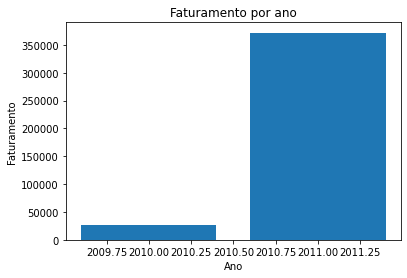

In [21]:
orders = data.groupby(by=['invoice_year'], as_index=False)['revenue'].count()
plt.title('Faturamento por ano')
plt.xlabel('Ano')
plt.ylabel('Faturamento')
plt.bar(orders.invoice_year, orders.revenue)

In [30]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [29]:
data['InvoiceDate'].describe()

<ipython-input-29-b45d2d7a7dfa>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data['InvoiceDate'].describe()


count                  397924
unique                  17286
top       2011-11-14 15:27:00
freq                      542
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

### Separação das bases para predição do proximo dia de compra

Teremos dois dataframes, o dataframe histórico contendo as vendas anteriores a 01/09/2011 e o dataframe que representa o futuro, contendo as vendas posteriores a 01/09/2011

In [31]:
data_hist = data[(data.InvoiceDate < date(2011,9,1))].reset_index(drop=True)
data_next = data[(data.InvoiceDate >= date(2011,9,1))].reset_index(drop=True)

TypeError: Invalid comparison between dtype=datetime64[ns] and date

In [9]:
data_hist['InvoiceDate'].describe()

NameError: name 'data_hist' is not defined

In [12]:
data_next['InvoiceDate'].describe()

count                  221204
unique                   8383
top       2011-10-31 14:41:00
freq                     1114
first     2011-09-01 08:25:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [10]:
data_clientes = pd.DataFrame(data_hist['CustomerID'].unique())
data_clientes.columns = ['CustomerID']

NameError: name 'data_hist' is not defined

In [17]:
data_clientes.head()

,CustomerID
0,17850.0
1,13047.0
2,12583.0
3,13748.0
4,15100.0
